# ADNI ConvNet

In [1]:
%matplotlib notebook

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
import nibabel as nib
import datetime as dt

import os
import os.path as osp
import glob

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from torch.utils.data import TensorDataset, DataLoader, Dataset

from tqdm.notebook import tqdm, trange

In [3]:
DATA_ROOT = "data"
MODEL_ROOT = "model"

TEST_PATH = osp.join(DATA_ROOT, "AD", "mwp1AD_4001_037_MR_MT1__GradWarp__N3m_Br_20120412210525847_S100198_I297310.nii.gz")

EPOCHS = 20
BATCH_SIZE = 4

In [4]:
test = nib.load(TEST_PATH)
test_data = test.get_fdata()

In [5]:
test.shape

(121, 145, 121)

In [6]:
type(test)

nibabel.nifti1.Nifti1Image

In [7]:
test_data.mean()

0.062023163411995576

In [8]:
def get_xyz(data, threshold=0.1):
    xx, yy, zz = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), np.arange(data.shape[2]), indexing='ij')
    print(data.shape, xx.shape)
    idxs = data > threshold
    x = xx[idxs]
    y = yy[idxs]
    z = zz[idxs]
    return x, y, z

(121, 145, 121) (121, 145, 121)
(18673,)


<IPython.core.display.Javascript object>


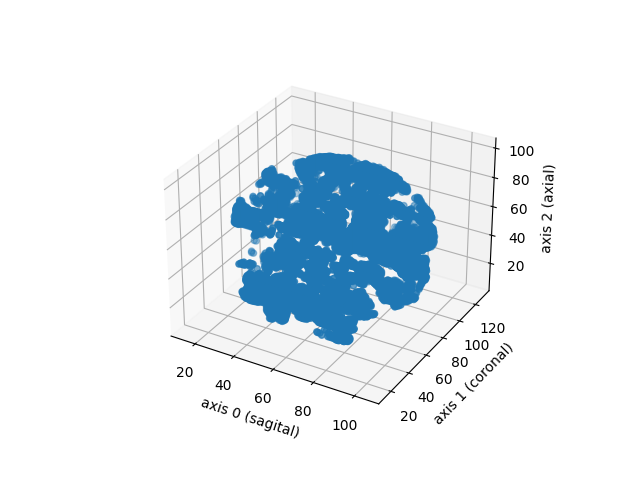

In [9]:
x, y, z = get_xyz(test_data, threshold=0.7)
print(x.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel("axis 0 (sagital)")
ax.set_ylabel("axis 1 (coronal)")
ax.set_zlabel("axis 2 (axial)")
#ax.scatter(x[::10], y[::10], z[::10])
ax.scatter(x, y, z)
plt.show()

In [10]:
def view_brain(data):
    #data = np.rot90(data,3,(1,2))
    AXES = ["sagital", "coronal", "axial"]
    ims = [0,1,2]
    sliders = []
    init_data = [data[0,:,:].T, data[:,0,:].T, data[:,:,0].T]
    
    fig, axs = plt.subplots(1, 3, figsize=(8,5))
    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8)

    for i in range(3):
        ims[i] = axs[i].imshow(init_data[i], cmap="gray", origin="lower")
        # axs[i].axis('off')
        axs[i].set_title(AXES[i])
        
        ax_slider = fig.add_axes([0.08 + i*0.3, 0.15, 0.24, 0.02])
        slider = Slider(
            label="",
            ax=ax_slider,
            valmin=0,
            valmax=data.shape[i]-1,
            valstep=1,
            valinit=0,
            orientation="horizontal",
            valfmt="%s"
        )
        #slider.valtext.set_visible(False)
        slider.label.set_visible(False)
        sliders.append(slider)

    def update(im, val, d):
        for i in range(3):
            axs[i].lines.clear()
        axs[0].axline((0, sliders[2].val), (1, sliders[2].val))
        axs[0].axline((sliders[1].val, 0), (sliders[1].val, 1))
        axs[1].axline((sliders[0].val, 0), (sliders[0].val, 1))
        axs[1].axline((0, sliders[2].val), (1, sliders[2].val))
        axs[2].axline((sliders[0].val, 0), (sliders[0].val, 1))
        axs[2].axline((0, sliders[1].val), (1, sliders[1].val))
        
        ims[im].set_data(d.T)
        ims[im].autoscale()
    
    sliders[0].on_changed(lambda val: update(0, val, data[int(val),:,:]))
    sliders[1].on_changed(lambda val: update(1, val, data[:,int(val),:]))
    sliders[2].on_changed(lambda val: update(2, val, data[:,:,int(val)]))
    
    return fig, axs, sliders

<IPython.core.display.Javascript object>


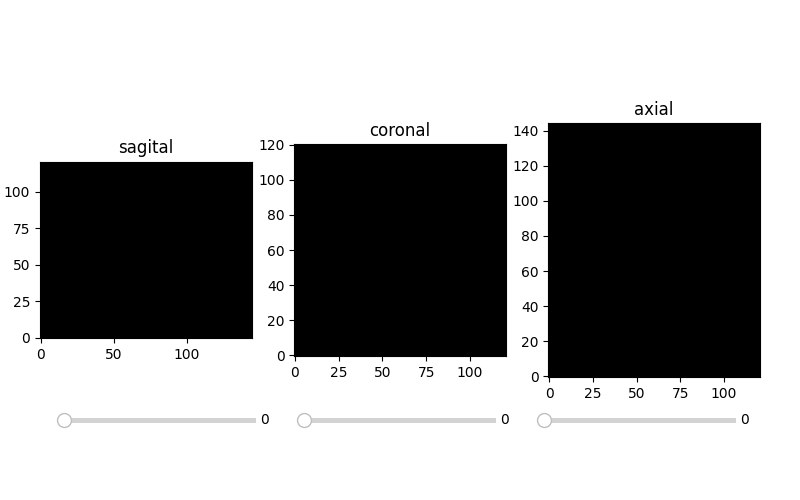

In [11]:
fig, axs, sliders = view_brain(test_data)
plt.show()

# create a 3d convnet

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, *args, **kwargs):
        super().__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, *args, **kwargs)
        self.batchnorm = nn.BatchNorm3d(out_channels)
        self.dropout = nn.Dropout3d(p=0.3)
        self.max_pool3d = nn.MaxPool3d(2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv3d(x)
        # batchnorm learns normalization parameters during training
        x = self.batchnorm(x)
        x = self.max_pool3d(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class ADNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cb1 = ConvBlock(1, 5, 3)
        self.cb2 = ConvBlock(5, 5, 3)
        self.cb3 = ConvBlock(5, 5, 3)
        self.cb4 = ConvBlock(5, 5, 3)
        self.linear = nn.Linear(875, 2)
    
    def forward(self, x):
        # in-dim: 121, 145, 121
        x = x.view(-1, 1, 121, 145, 121) # hinzufügen der Channel-Dimension
        # each convolutional block:
        # 1. makes each dimension 2 smaller (kernel size 3)
        # 2. halves the size of each dimension, rounded down (maxpool3d)
        x = self.cb1(x)
        # 5 (channels) * f(119/2) = 59 * f(143/2) = 71 * f(119/2) = 59
        x = self.cb2(x)
        # 5 (channels) * f(57/2) = 28 * f(69/2) = 34 * f(57/2) = 28
        x = self.cb3(x)
        # 5 (channels) * f(26/2) = 13 * f(32/2) = 16 * f(26/2) = 13
        x = self.cb4(x)
        # 5 (channels) * f(11/2) = 5 * f(14/2) = 7 * f(11/2) = 5
        x = x.view(-1, 875) # flatten
        x = self.linear(x)
        return F.softmax(x, dim=1)

In [5]:
adnet = ADNet()

In [6]:
# don't provide batch dimension for torch summary!
summary(adnet, input_size=(121,145,121))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 5, 119, 143, 119]             140
       BatchNorm3d-2     [-1, 5, 119, 143, 119]              10
         MaxPool3d-3        [-1, 5, 59, 71, 59]               0
              ReLU-4        [-1, 5, 59, 71, 59]               0
         Dropout3d-5        [-1, 5, 59, 71, 59]               0
         ConvBlock-6        [-1, 5, 59, 71, 59]               0
            Conv3d-7        [-1, 5, 57, 69, 57]             680
       BatchNorm3d-8        [-1, 5, 57, 69, 57]              10
         MaxPool3d-9        [-1, 5, 28, 34, 28]               0
             ReLU-10        [-1, 5, 28, 34, 28]               0
        Dropout3d-11        [-1, 5, 28, 34, 28]               0
        ConvBlock-12        [-1, 5, 28, 34, 28]               0
           Conv3d-13        [-1, 5, 26, 32, 26]             680
      BatchNorm3d-14        [-1, 5, 26,

# Create a DataSet

In [28]:
cn_files = glob.glob(osp.join(DATA_ROOT, "CN", "*.nii.gz"))
ad_files = glob.glob(osp.join(DATA_ROOT, "AD", "*.nii.gz"))

cn_split = int(len(cn_files) * 0.9)
ad_split = int(len(ad_files) * 0.9)

cn_train = cn_files[:cn_split]
cn_test = cn_files[cn_split:]
ad_train = ad_files[:ad_split]
ad_test = ad_files[ad_split:]

In [29]:
class AdniDataset(Dataset):
    
    def __init__(self, cn_files, ad_files, transform=None):
        self.cn_files = cn_files
        self.ad_files = ad_files
        self.transform = transform

    def __len__(self):
        return len(self.ad_files) + len(self.cn_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        y = 0 if idx < len(self.cn_files) else 1
        path = (self.cn_files + self.ad_files)[idx]
        
        img = nib.load(path)
        x = torch.tensor(img.get_fdata()).float()

        if self.transform:
            x = self.transform(x)

        return (x, y)

In [30]:
train_ds = AdniDataset(cn_train, ad_train)
train_loader = DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)

test_ds = AdniDataset(cn_test, ad_test)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=BATCH_SIZE)

In [31]:
adnet.train()
optimizer = torch.optim.Adam(adnet.parameters())

pbar = trange(EPOCHS * len(loader))

for epoch in range(EPOCHS):
    for batch_id, (X, y_target) in enumerate(loader):
        adnet.zero_grad()
        y_pred = adnet(X)
        loss = F.nll_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        pbar.update()
        pbar.set_description("{} / {}: {:.3f}".format(epoch, EPOCHS, loss))

  0%|          | 0/2220 [00:00<?, ?it/s]

torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])


KeyboardInterrupt: 

In [37]:
adnet.eval()
correct = 0
total = 0

for batch_id, (X, y_target) in enumerate(test_loader):
    y_pred = adnet(X)
    vals, idxs = y_pred.max(dim=1)
    correct += (idxs == y_target).sum()
    total += len(y_target)

accuracy = correct / total

print("Accuracy: {:.3f}".format(accuracy))

torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([4, 2])
torch.Size([1, 2])
Accuracy: 0.578


In [8]:
if not osp.exists(MODEL_ROOT):
    os.makedirs(MODEL_ROOT)

timestamp = dt.datetime.now().strftime("%Y%M%D-%H%M%S")
torch.save(adnet.state_dict(), osp.join(MODEL_ROOT, "model-{}.pt".format()

In [ ]:
# Maybe Create a Tensor Dataset instead
# could be small enough to load all files into the ram at once
# still seems to be to much, lets stick with lazy load first

In [ ]:
#def load_nifti(path):
#    files = glob.glob(osp.join(path, "*.nii.gz"))
#    X = []
#    for fpath in files:
#        img = nib.load(fpath)
#        x = torch.tensor(img.get_fdata())
#        X.append(x)
#        del img
#    return X

In [ ]:
#cn_imgs = load_nifti(osp.join(DATA_ROOT, "CN"))

In [ ]:
#ad_imgs = load_nifti(osp.join(DATA_ROOT, "AD"))

In [ ]:
#X = torch.stack(cn_imgs + ad_imgs)
#y = [0] * len(cn_files) + [1] * len(ad_files)
#dataset = TensorDataset(X, y)